In [2]:
from pympi.Elan import Eaf
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import librosa
from dataclasses import asdict
from annotation.visualize import plot_gender
import matplotlib.pyplot as plt
import jiwer
import textgrid

from annotation import FundamentalFrequencyAnnotator, GenderClassification

In [3]:
root = Path('/home/t9s9/Documents/Uni/MMC-PR/')
exp_names = list(map(lambda x: x.stem[:-2], (root / 'AudioOut').iterdir()))
exp_names.remove('V8')
print(exp_names)

sr = 441000

['V22', 'V10', 'V1', 'V4', 'V3', 'V9', 'V13', 'V23', 'V20', 'V16', 'V2', 'V5', 'V6', 'V7', 'V21', 'V24', 'V25', 'V11']


In [1]:
def load(exp):
    eaf = Eaf(root / f'SaGADateienIS/Grob{exp}.eaf')
    audio_file = root / f'AudioOut/{exp}K2.mp3'

    with open(root / f'annot/{exp}K2.pkl', 'rb') as f:
        transcription = pickle.load(f)

    with open(root / f'f0/{exp}K2.pkl', 'rb') as f:
        f0_raw = pickle.load(f)

    f0 = f0_raw[..., 1]
    times = f0_raw[..., 0] * 1000
    return eaf, transcription, f0, times

In [180]:
def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]


def apply(func):
    return flatten(map(func, map(load, exp_names)))

In [164]:
eaf, transcription, f0, times = load('V1')

In [165]:
tiers = ['DStroke', 'DApex', 'IApex', 'InformationStatus', 'Focus', 'Pitch accents']
for segment in transcription.segments:
    seg_start, seg_end = segment.start * 1000, segment.end * 1000

    for tier in tiers:
        annot = eaf.get_annotation_data_between_times(tier, seg_start, seg_end)

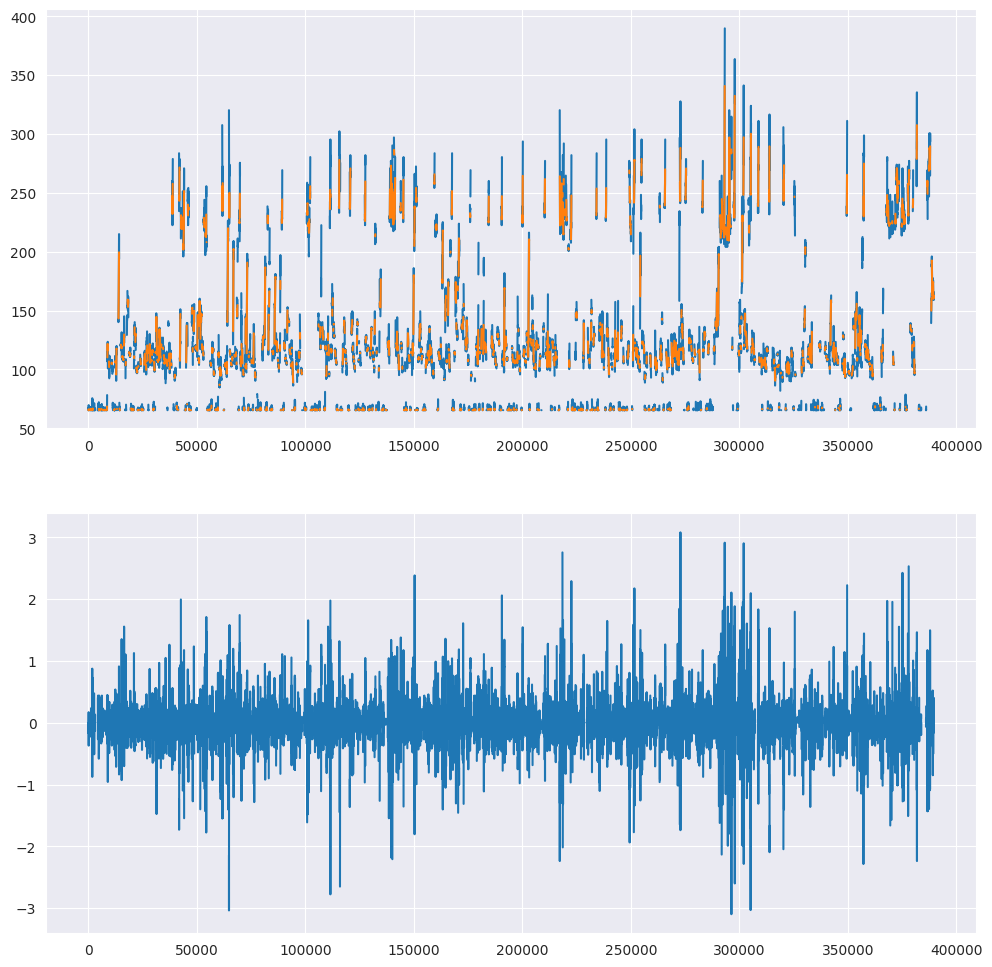

In [166]:
f0_dx = np.diff(f0) / np.diff(times)
N = 10
f0_running_mean = np.convolve(f0, np.ones((N,)) / N, mode='same')

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(times, f0, label='f0')
ax[0].plot(times, f0_running_mean, label='running_mean')
ax[1].plot(times[1:], f0_dx)

In [167]:
tiers = eaf.get_tier_names()
tiers = ['DStroke', 'DApex', 'IApex', 'InformationStatus', 'Focus', 'Pitch accents']

for tier in tiers:
    try:
        print(f"{tier}: {set(map(lambda x: x[-1], eaf.get_annotation_data_for_tier(id_tier=tier)))}")
    except:
        continue

DStroke: {'stroke'}
DApex: {'a'}
IApex: {'i'}
InformationStatus: {'new', 'acc', 'giv'}
Focus: {'cf', 'nf'}
Pitch accents: {'!H*', 'H', 'L*', 'H+H*', 'L+H*', 'H*+L', 'H*', 'L*+H', 'H+L*'}


In [213]:


def f0_regression(inputs):
    _eaf, _, _f0, _times = inputs
    data = []
    for i, (start, end, annot) in enumerate(_eaf.get_annotation_data_for_tier(id_tier='InformationStatus')):
        annot = annot.strip()
        idx = np.where((_times >= start) & (_times <= end))[0]
        annot_f0 = _f0[idx]
        annot_times = _times[idx]
        not_na = np.where(~np.isnan(annot_f0))[0]

        gender = GenderClassification(verbose=False).get_gender(annot_f0[not_na])

        if not not_na.size:
            continue

        m, b = np.polyfit(annot_times[not_na], annot_f0[not_na], 1)

        # plt.scatter(annot_times, annot_f0)
        # x = np.linspace(annot_times.min(), annot_times.max(), num=100)
        # y = m*x+b
        # plt.plot(x, y)
        # plt.show()
        # break
        data.append(dict(InformationStatus=annot, m=m, gender=gender))
    return data


df = pd.DataFrame(apply(f0_regression))
df.InformationStatus = df.InformationStatus.replace(dict(accc='acc', ycc='acc', ac='acc'))

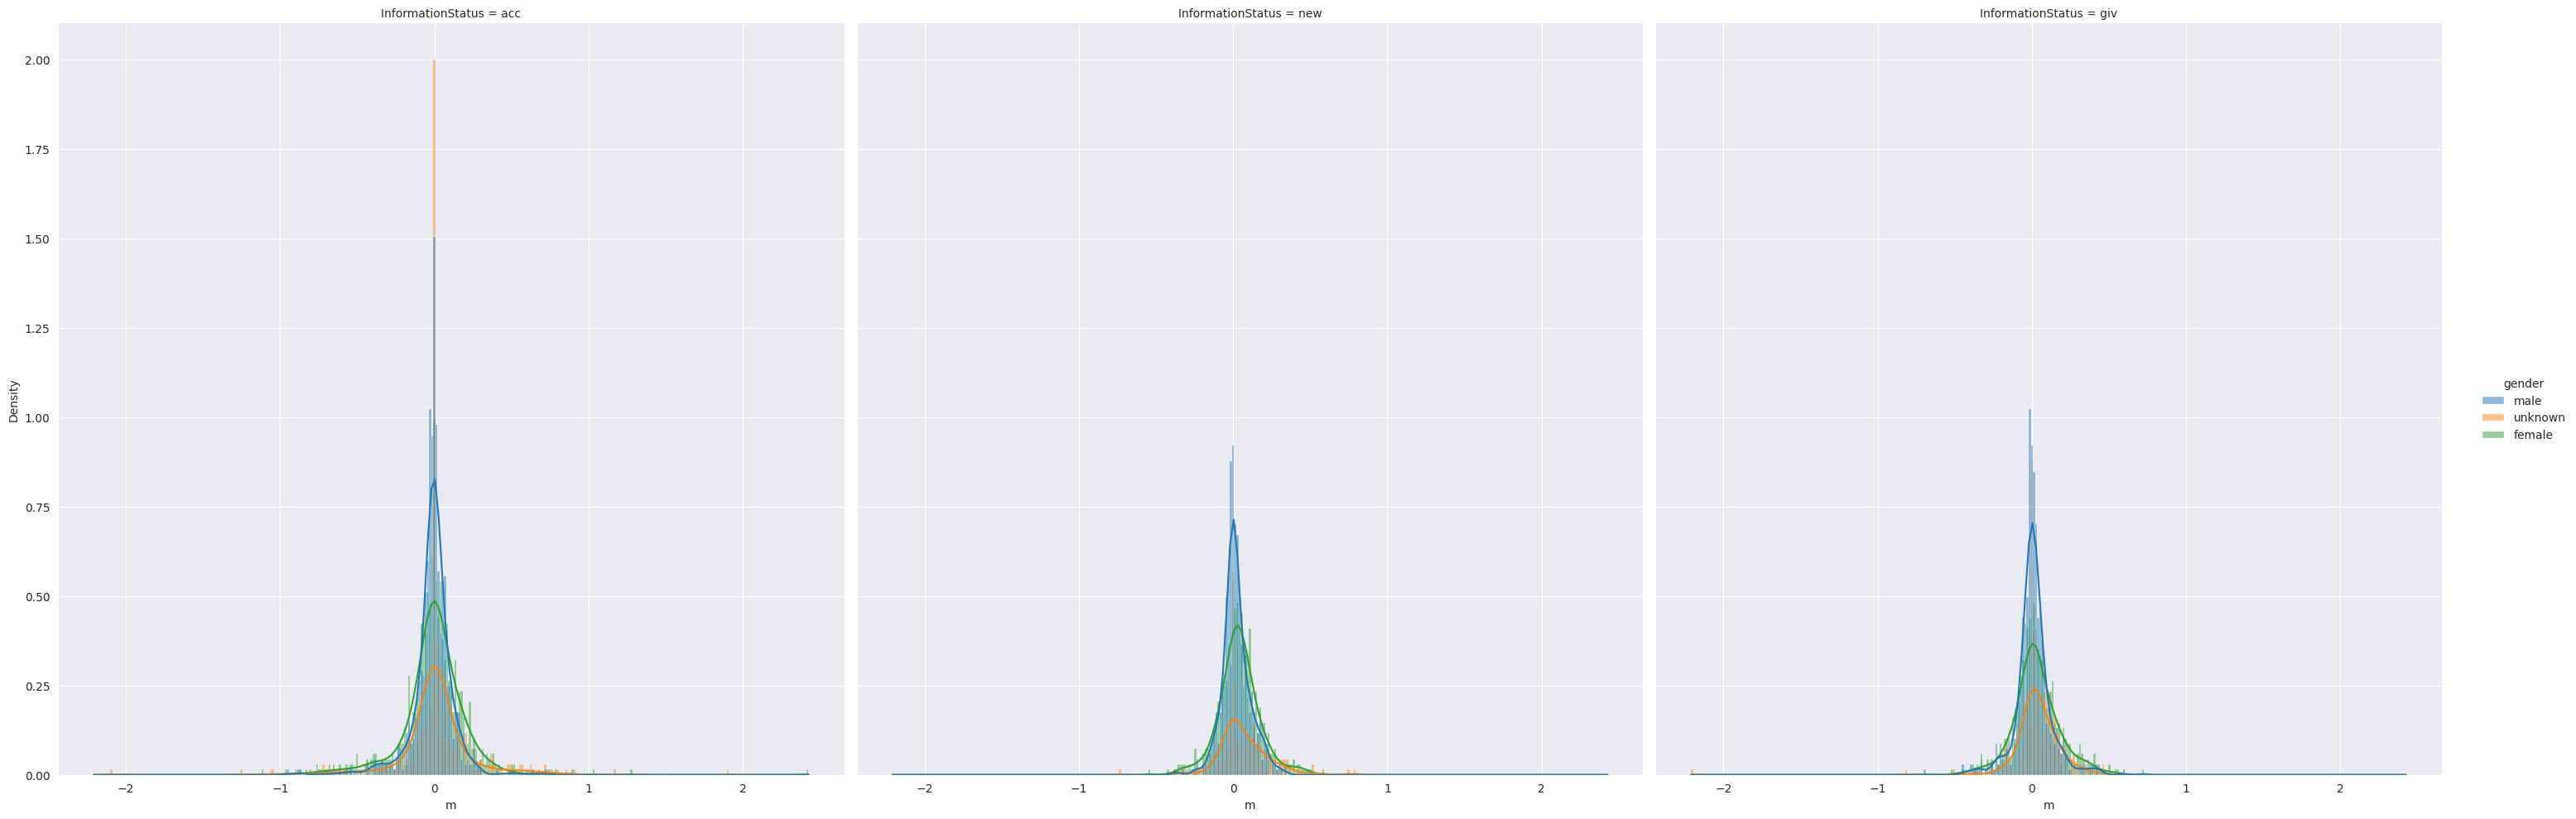

In [214]:
sns.displot(df, col='InformationStatus', x='m', kind='hist',
            kde=True,
            stat='density',
            height=10,
            hue='gender'
            )

In [210]:


def f0_regression(inputs):
    _eaf, _, _f0, _times = inputs
    data = []
    for i, (start, end, annot) in enumerate(_eaf.get_annotation_data_for_tier(id_tier='Focus')):
        annot = annot.strip()
        idx = np.where((_times >= start) & (_times <= end))[0]
        annot_f0 = _f0[idx]
        annot_times = _times[idx]
        not_na = np.where(~np.isnan(annot_f0))[0]

        gender = GenderClassification(verbose=False).get_gender(annot_f0[not_na])

        if not not_na.size:
            continue

        m, b = np.polyfit(annot_times[not_na], annot_f0[not_na], 1)

        # plt.scatter(annot_times, annot_f0)
        # x = np.linspace(annot_times.min(), annot_times.max(), num=100)
        # y = m*x+b
        # plt.plot(x, y)
        # plt.show()
        # break
        data.append(dict(Focus=annot, m=m, gender=gender))
    return data


df = pd.DataFrame(apply(f0_regression))
df.Focus = df.Focus.replace(dict(nF='nf', Background='cv'))

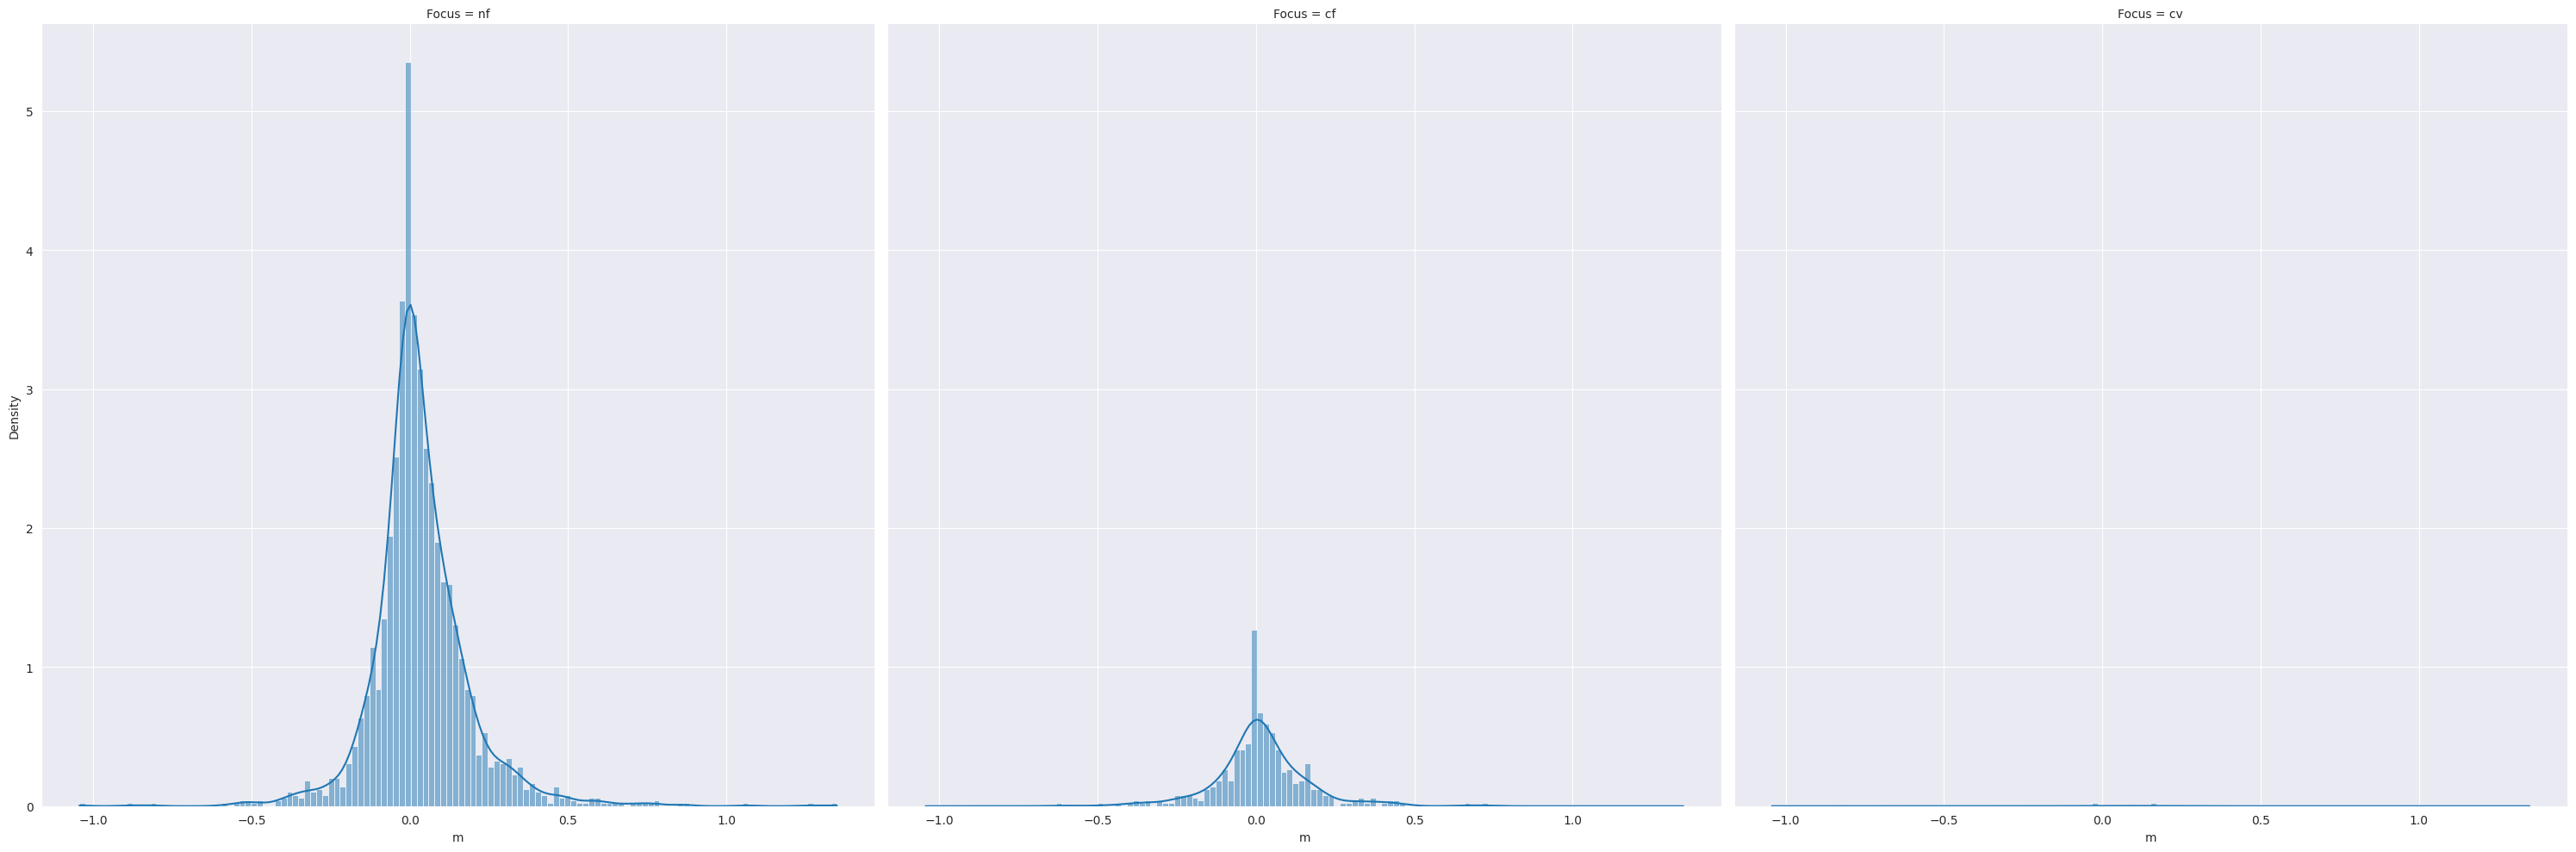

In [211]:
sns.displot(df, col='Focus', x='m', kind='hist',
            kde=True,
            stat='density',
            height=10,
            # hue='gender'
            )

In [ ]:
ds = []

for tier in ['Pitch accents']:
    for s, e, a in eaf.get_annotation_data_for_tier(id_tier=tier):
        a = a.strip()
        idx = np.where((times >= s) & (times <= e))[0]
        this_f0 = f0[idx]
        #     closest_not_nan = np.where(~np.isnan(f0[:idx[0]]))[0]
        #     this_f0 = f0[closest_not_nan[-1]]
        #     this_f0_dx = f0_dx[closest_not_nan[-2]]
        # else:

        this_f0 = np.nanmean(this_f0)
        this_f0_dx = np.nanmean(f0_dx[idx])

        ds.append(dict(tier=tier, annot=a, f0=this_f0, f0dx=this_f0_dx))

In [85]:
df = pd.DataFrame(ds)
df['speech'] = df.f0.isna()
df

,tier,annot,f0,f0dx,speech
0,Pitch accents,H*,101.748642,-0.025165,False
1,Pitch accents,L*,99.711849,-0.196161,False
2,Pitch accents,H*,115.204275,-0.142058,False
3,Pitch accents,H*,116.542885,0.087225,False
4,Pitch accents,!H*,123.717508,0.165730,False
...,...,...,...,...,...
194,Pitch accents,L*,NaN,NaN,True
195,Pitch accents,L+H*,124.187466,0.082860,False
196,Pitch accents,H*,NaN,NaN,True
197,Pitch accents,H*,108.126498,-0.181331,False


In [90]:
df.groupby(['tier', 'annot']).mean()

f0      f0dx    speech
tier          annot                                
Pitch accents !H*    116.755336 -0.056869  0.187500
              H*     142.537064 -0.011698  0.147059
              H*+L   130.339912 -0.204114  0.000000
              L*     103.784864 -0.086633  0.444444
              L*+H          NaN       NaN  1.000000
              L+H*   118.014466  0.145840  0.121951